In [33]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from metrics import *
from tree.base import DecisionTree,Node

from calendar import c
from typing import Literal

np.random.seed(42)

In [34]:

def accuracy(y_hat: pd.Series, y: pd.Series):
    assert y_hat.size == y.size

    correct_predictions = sum(a == p for a, p in zip(y, y_hat))
    total_predictions = len(y)
    
    accuracy = correct_predictions / total_predictions
    return accuracy
    

def precision(y_hat: pd.Series, y: pd.Series, cls: Union[int, str]):
    true_positives=y_hat[y == cls].value_counts().get(cls,0)
    total_prediction=len([y_hat == cls])

    print(y_hat)
    print("true_postivi" , true_positives)

    if total_prediction == 0:
        return 0.0  # Avoid division by zero

    precision = true_positives / total_prediction
    return precision


def recall(y_hat: pd.Series, y: pd.Series, cls: Union[int, str]):
    true_positives=y_hat[y == cls].value_counts().get(cls,0)
    total_actual=len([y == cls])

    if total_actual == 0:
        return 0.0
    recall = true_positives / total_actual
    return recall


def rmse(y_hat: pd.Series, y: pd.Series):
    assert ValueError("Input lists must have the same length.")

    squared_errors = (y - y_hat) ** 2 
    mean_squared_error = squared_errors.mean()
    rmse = np.sqrt(mean_squared_error)
    return rmse


def mae(y_hat: pd.Series, y: pd.Series):
    assert ValueError("Input lists must have the same length.")

    squared_errors = (y - y_hat) ** 2 
    return squared_errors.mean()


In [35]:
def check_ifreal(y: pd.Series):
    if y.dtype.name == "category":
        return False
    return True

def entropy(Y: pd.Series):
    unique_class, class_counts = np.unique(Y, return_counts=True)
    probability = class_counts/len(Y)
    return -np.sum(probability * np.log2(probability))

def gini_index(y):
    unique_class, class_counts = np.unique(y, return_counts=True)
    probability = class_counts/len(y)
    return 1-np.sum(probability ** 2)

def MSE(target,mean):
    return ((target - mean) ** 2).mean()

#by default calculating entropy, when information_gain is given as criterion
#for real output we need to set the crirerion as MSE 
def information_gain(attr: pd.DataFrame, Y: pd.Series, feature_idx):
    # conataining unique value of particular feature
    unique_classs = np.unique(attr[feature_idx])
    node_entropy=0
    total_child_entropy = 0
    
    node_entropy = Y.mean()
    for value in unique_classs:
        # taking sub part of target which has same value for the feature
        child_target = Y[attr[feature_idx] == value]
        total_child_entropy += len(child_target) / \
            len(Y) * MSE(child_target,node_entropy)

    return node_entropy-total_child_entropy

def opt_split_attribute(X: pd.DataFrame, y: pd.Series, criterion="information_gain"):
    """
    Function to find the optimal attribute to split about.
    If needed you can split this function into 2, one for discrete and one for real valued features.
    You can also change the parameters of this function according to your implementation.

    features: pd.Series is a list of all the attributes we have to split upon

    return: attribute to split upon
    """

    # According to wheather the features are real or discrete valued and the criterion, find the attribute
    #  from the features series with the maximum information gain
    #  (entropy or varinace based on the type of output) or minimum gini index (discrete output).

    best_feature=0

    if criterion =="information_gain":
        max_info_gain=0
        for column_name in X.columns:
            new_info_gain=information_gain(X,y,column_name)
            if new_info_gain > max_info_gain:
                max_info_gain=new_info_gain
                best_feature=column_name
    else :
        gini_value=float('inf')
        for column_name in X.columns:
            new_gini=gini_index(X[column_name])
            if new_gini < gini_value:
                gini_value=new_gini
                best_feature=column_name
    
    return best_feature


def split_data(X: pd.DataFrame, y: pd.Series, attribute, value):
    """
    Funtion to split the data according to an attribute.
    If needed you can split this function into 2, one for discrete and one for real valued features.
    You can also change the parameters of this function according to your implementation.

    attribute: attribute/feature to split upon
    value: value of that attribute to split upon

    return: splitted data(Input and output)
    """


    # Split the data based on a particular value of a particular attribute. 
    # You may use masking as a tool to split the data.

    

In [36]:
class Node:
    def __init__(self, data=None, feature_value=None,target=None,child=None,result=None):
        self.data = data  # data corresponding to the node [matrix]
        self.target = target  # y data
        self.children = child  # child names & objects
        self.feature = feature_value  # value at node
        self.result = result

    def plot(self, level=0):
        indent = "  " * level
        print(f"{indent}|- {self.feature}: {self.result}")
        if self.children is not None:
            for child in self.children:
                self.children[child].plot(level + 1)

class DecisionTree:
    # criterion won't be used for regression
    criterion: Literal["information_gain", "gini_index"]
    max_depth: int  # The maximum depth the tree can grow to
    root = None

    def __init__(self, criterion, max_depth=5):
        self.criterion = criterion
        self.max_depth = max_depth

    # def fit_DI_DO(self, data_frame: pd.DataFrame, target: pd.Series, depth=0,criterion="information_gain"):
    #     return self.id3(data_frame,target,depth)

    def id3(self,data_frame: pd.DataFrame, target: pd.Series, depth=0,criterion="information_gain"):
            # If all instances have the same target value, create a leaf node

            #in clase of real output, storing the mean at the leaf node
            #no split of data set is possible when we have 2 or lesser samples
            if target.size <= 2:
                mean_value = target.mean()
                return Node(result=mean_value)

            # If there are no more features to split on, create a leaf node with the majority class
            if len(list(data_frame.columns)) == 0:
                mean_value = target.mean()
                return Node(result=mean_value)

            # If maximum depth is reached, create a leaf node with the majority class
            if self.max_depth is not None and depth == self.max_depth:
                mean_value = target.mean()
                return Node(result=mean_value)
           
            # Choose the best feature to split on based on information gain considering only single level in tree
            best_attribute=opt_split_attribute(data_frame,target,criterion=criterion)
            root=Node(data=data_frame,target=target,feature_value=best_attribute,child={})

            for value in np.unique(data_frame[best_attribute]):
                subset_idx=data_frame[best_attribute] == value
                subset_data = data_frame[subset_idx]
                subset_target = target[subset_idx]
                if len(subset_target) > 0 :
                    root.children[value]=self.id3(subset_data, subset_target,depth=depth + 1)
                
            return root

    def predict_multiway(self,tree, sample):
        # Reached a leaf node which contains the result value, return the result
        if tree.result is not None:
            return tree.result

        # Not a leaf node, continue traversing the tree
        feature_value = sample[tree.feature]

        if feature_value in tree.children:
            child_node = tree.children[feature_value]
            return self.predict_multiway(child_node, sample)
        else:
            # Handle missing values or unknown values as needed
            return None

    def fit(self, X: pd.DataFrame, y: pd.Series):
        # if check_ifreal(y):
        #     return self.id3(X,y,depth=0,criterion="MSE")     
        # else:
        #      return self.id3(X,y,depth=0,criterion=self.criterion)  
        return self.id3(X,y,depth=0,criterion=self.criterion) 

    def predict(self, tree,X):
        return self.predict_multiway(tree,X)

    def plot(self):
        """
        Function to plot the tree

        Output Example:
        ?(X1 > 4)
            Y: ?(X2 > 7)
                Y: Class A
                N: Class B
            N: Class C
        Where Y => Yes and N => No
        """
        if self.root is not None:
            self.root.plot()

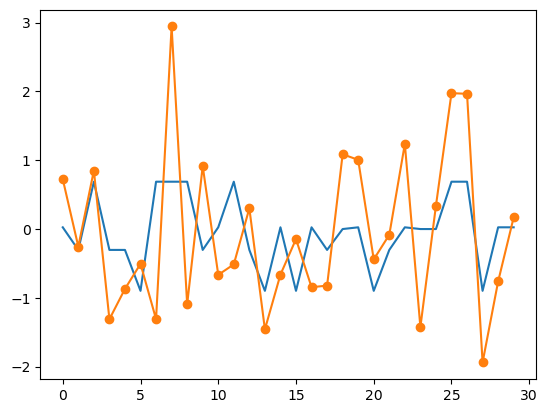

|- 0: None
  |- 0: None
    |- 0: None
      |- 0: None
        |- 0: None
          |- None: -0.0005764009370457327
  |- 0: None
    |- 0: None
      |- 0: None
        |- 0: None
          |- None: -0.8986620378378308
  |- 0: None
    |- 0: None
      |- 0: None
        |- 0: None
          |- None: 0.6875980867743584
  |- 0: None
    |- 0: None
      |- 0: None
        |- 0: None
          |- None: 0.024662834759845653
  |- 0: None
    |- 0: None
      |- 0: None
        |- 0: None
          |- None: -0.3039773069081027
Criteria : information_gain
RMSE:  1.0239014923025638
MAE:  1.048374265939417


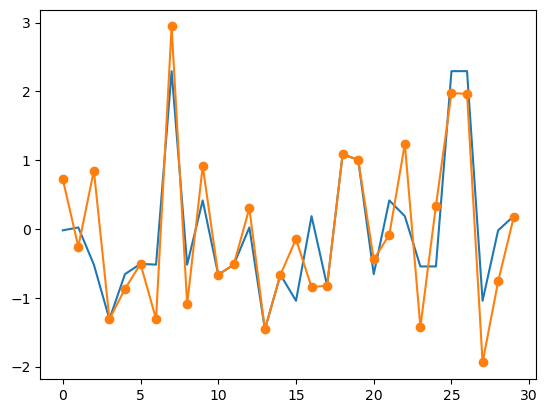

|- 4: None
  |- None: -0.6560354888935434
  |- 0: None
    |- None: 1.0867270230392738
    |- None: -0.019271856344637295
    |- None: -0.8224893687800624
  |- 0: None
    |- None: -1.0431920126724297
    |- None: -0.6643994668043212
    |- None: -1.3113242257511093
  |- 0: None
    |- None: -0.5442281129252056
    |- None: -0.5066432196315238
    |- 0: None
      |- 0: None
        |- 0: None
          |- None: 2.294423125786745
    |- 0: None
      |- 0: None
        |- 0: None
          |- None: 0.18655281455801667
    |- None: 0.02277908199534598
  |- 0: None
    |- None: -1.4585169209867577
    |- 0: None
      |- 0: None
        |- 0: None
          |- None: -0.5175206924849316
    |- None: 1.004986880702632
    |- None: 0.41535961837241736
Criteria : gini_index
RMSE:  0.595853997844436
MAE:  0.35504198674719717


In [37]:
N = 30
P = 5
X = pd.DataFrame({i: pd.Series(np.random.randint(P, size=N), dtype="category") for i in range(5)})
y = pd.Series(np.random.randn(N))

for criteria in ["information_gain", "gini_index"]:
    tree = DecisionTree(criterion=criteria)  # Split based on Inf. Gain
    root=tree.fit(X, y)
    y_hat=[]
    for idx,x in X.iterrows():
        y_hat.append(tree.predict(root,x))
    # print(y_hat)

    plt.plot(range(30),y_hat)
    plt.plot(range(30),y,marker='o')
    plt.show()

    root.plot()
    print("Criteria :", criteria)

    print("RMSE: ", rmse(y_hat, y))
    print("MAE: ", mae(y_hat, y))